# Multi-Run QoC Analysis (v2) — Turtlebots over 5G

**Fixes**: run-level QoC definitions that vary across runs; richer plots (trajectories, speeds, reliability).

Bag root: 
Found 22 bags
✔ 2tb4_0SINR_besteffort_maxspeed_0.db3
✔ 2tb4_35SINR_besteffort_maxspeed_0.db3
✔ 2tb4_35SINR_besteffort_maxspeed_2_0.db3
✔ 2tb4_LIVE_SINR_besteffort_0.15speed_0.db3
✔ 2tb4_LIVE_SINR_besteffort_0.3speed_0.db3
✔ 2tb4_LIVE_SINR_besteffort_0.3speed_2_0.db3
✔ 2tb4_LIVE_SINR_besteffort_0.3speed_3_0.db3
✔ 2tb4_LIVE_SINR_besteffort_maxspeed_0.db3
✔ 2tb4_0SINR_besteffort_maxspeed_0.db3
✔ rosbag2_2025_10_27-20_37_41_0.db3
✔ 2tb4_35SINR_besteffort_maxspeed_2_0.db3
✔ 2tb4_LIVE_SINR_besteffort_maxspeed_0.db3
✔ rosbag2_2025_10_27-21_04_45_0.db3
✔ 2tb4_0SINR_reliable_maxspeed_0.db3
✔ 2tb4_35SINR_reliable_maxspeed_0.db3
✔ 2tb4_LIVE_SINR_reliable_0.15speed_0.db3
✔ 2tb4_LIVE_SINR_reliable_0.3speed_0.db3
✔ 2tb4_LIVE_SINR_reliable_maxspeed_0.db3
✔ 2tb4_LIVE_SINR_reliable_maxspeed_2_0.db3
✔ Hallway_35_SINR_reliable_maxspeed_0.db3
✔ Hallway_LIVE_SINR_reliable_maxspeed_0.db3
✔ 2tb4_LIVE_SINR_reliable_maxspeed_2_0.db3


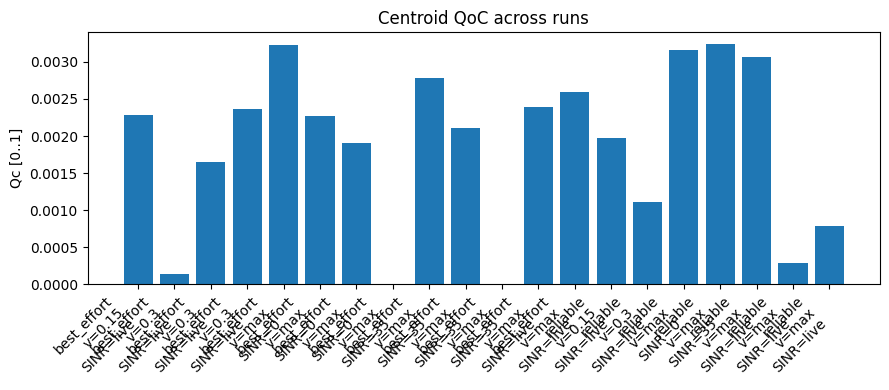

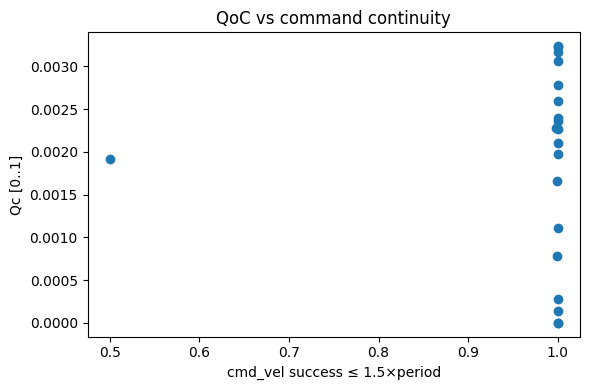

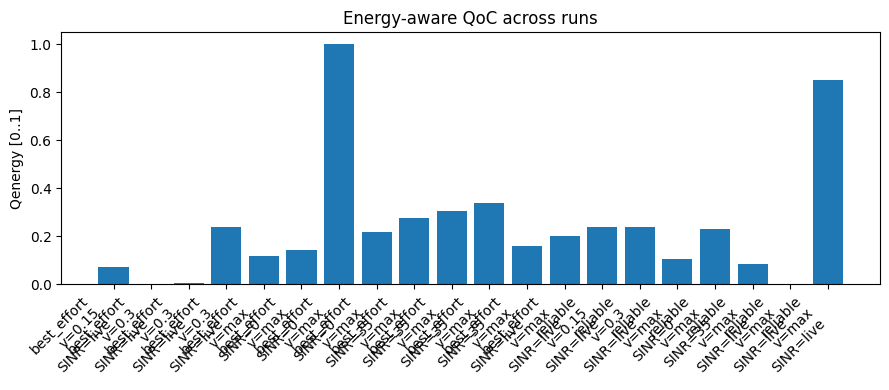

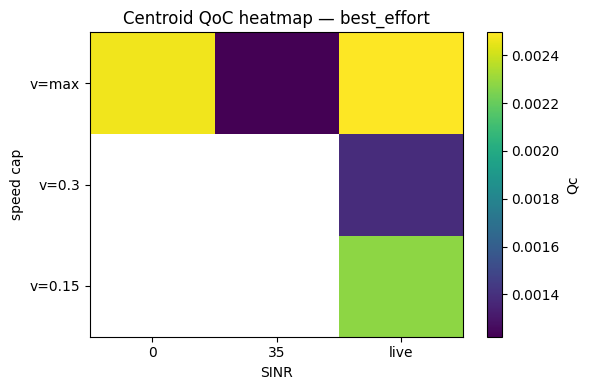

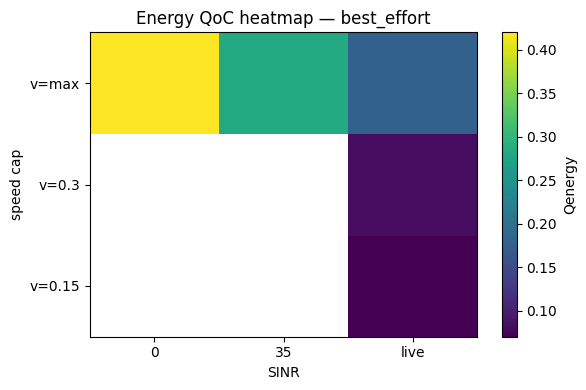

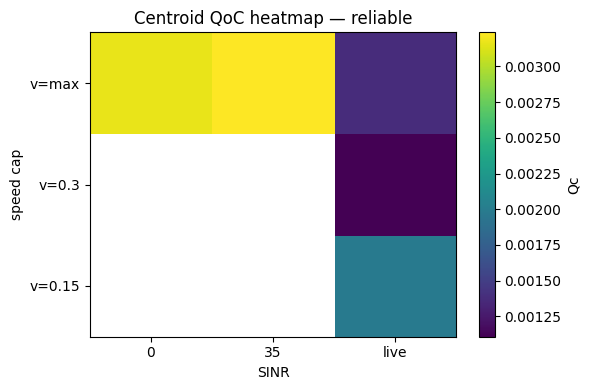

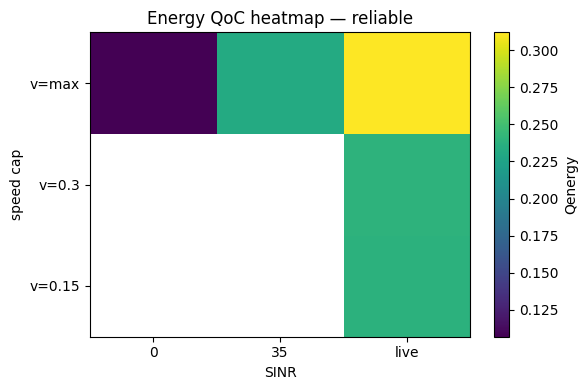

In [16]:
# ===========================
# Multi-Run QoC Analysis v4
# ===========================
# pip install -U rosbags numpy pandas matplotlib

# --- Config ---
BAG_ROOT    = ""       # parent with *.db3 (recursively)
ROBOT_NS    = ["tb4_1", "tb4_2"]
DT_RESAMPLE = 0.05              # seconds
OUTDIR      = "qoc_v4_out"

import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

os.makedirs(OUTDIR, exist_ok=True)
print("Bag root:", BAG_ROOT)

# --- Discover bags & parse metadata ---
def find_bags(root):
    return sorted(glob.glob(os.path.join(root, "**", "*.db3"), recursive=True))

def parse_meta_from_name(path):
    name   = os.path.basename(path).lower()
    parent = os.path.basename(os.path.dirname(path)).lower()
    text   = f"{parent}__{name}".replace(" ", "_")
    qos = "best_effort" if "besteffort" in text else ("reliable" if "reliable" in text else "unknown")
    sinr = None
    m = re.search(r"(\d+)\s*?sinr", text)
    if m: sinr = float(m.group(1))
    if "live_sinr" in text: sinr = np.nan
    speed = None
    m2 = re.search(r"(\d+(\.\d+)?)\s*speed", text)
    if m2: speed = float(m2.group(1))
    if "maxspeed" in text: speed = "max"
    return {"qos": qos, "sinr": sinr, "speed": speed, "label": os.path.basename(path)}

bags    = find_bags(BAG_ROOT)
meta_df = pd.DataFrame([dict(path=b, **parse_meta_from_name(b)) for b in bags])
print(f"Found {len(bags)} bags")

# --- rosbags helpers ---
from rosbags.highlevel import AnyReader
from rosbags.typesys   import get_typestore, Stores

def make_typestore():
    for c in (Stores.ROS2_HUMBLE, Stores.ROS2_IRON, Stores.ROS2_JAZZY, Stores.ROS2_FOXY):
        try:
            return get_typestore(c)
        except Exception:
            pass
    return get_typestore(Stores.ROS2_HUMBLE)

def list_topics(reader):
    return sorted({c.topic for c in reader.connections})

def extract_odom(reader, topic):
    conns = [c for c in reader.connections if c.topic == topic]
    rows  = []
    for conn in conns:
        for _conn, t_ns, raw in reader.messages(connections=[conn]):
            msg = reader.deserialize(raw, conn.msgtype)
            t   = t_ns * 1e-9
            try:
                hs = msg.header.stamp.sec + 1e-9*msg.header.stamp.nanosec
                if hs > 0 and abs(hs - t) < 1.0 and (not rows or hs >= rows[-1][0]):
                    t = hs
            except Exception:
                pass
            x  = getattr(msg.pose.pose.position,  "x", float("nan"))
            y  = getattr(msg.pose.pose.position,  "y", float("nan"))
            z  = getattr(msg.pose.pose.position,  "z", float("nan"))
            vx = getattr(msg.twist.twist.linear, "x", float("nan"))
            vy = getattr(msg.twist.twist.linear, "y", float("nan"))
            vz = getattr(msg.twist.twist.linear, "z", float("nan"))
            rows.append((t,x,y,z,vx,vy,vz))
    if not rows: return None
    df = pd.DataFrame(rows, columns=["t","x","y","z","vx","vy","vz"]).sort_values("t").drop_duplicates("t")
    return df

def extract_cmdvel(reader, topic):
    conns = [c for c in reader.connections if c.topic == topic]
    rows  = []
    for conn in conns:
        for _conn, t_ns, raw in reader.messages(connections=[conn]):
            msg = reader.deserialize(raw, conn.msgtype)
            t   = t_ns * 1e-9
            try:
                hs = msg.header.stamp.sec + 1e-9*msg.header.stamp.nanosec
                if hs > 0 and abs(hs - t) < 1.0 and (not rows or hs >= rows[-1][0]):
                    t = hs
            except Exception:
                pass
            vx = getattr(msg.linear,  "x", float("nan"))
            wz = getattr(msg.angular, "z", float("nan"))
            rows.append((t,vx,wz))
    if not rows: return None
    df = pd.DataFrame(rows, columns=["t","vx","wz"]).sort_values("t").drop_duplicates("t")
    return df

# --- Metrics ---
def resample_to_grid(trajs, dt):
    tmin = min(df["t"].min() for df in trajs.values())
    tmax = max(df["t"].max() for df in trajs.values())
    if not np.isfinite(tmin) or not np.isfinite(tmax) or tmax <= tmin:
        raise RuntimeError("Invalid time bounds for resampling.")
    t = np.arange(tmin, tmax + 0.5*dt, dt)
    out = {}
    for name, df in trajs.items():
        tt = df["t"].to_numpy()
        def interp_or_hold(values):
            arr = np.asarray(values); fin = np.isfinite(arr)
            if np.sum(fin) >= 2 and len(tt) >= 2:
                return np.interp(t, tt, arr, left=arr[fin][0], right=arr[fin][-1])
            val = arr[fin][0] if np.any(fin) else 0.0
            return np.full_like(t, float(val))
        out[name] = pd.DataFrame({
            "t": t,
            "x": interp_or_hold(df["x"]), "y": interp_or_hold(df["y"]), "z": interp_or_hold(df["z"]),
            "vx": interp_or_hold(df["vx"]), "vy": interp_or_hold(df["vy"]), "vz": interp_or_hold(df["vz"]),
        })
    return t, out

def centroid_qoc_runlevel(resampled):
    names = list(resampled.keys())
    T = resampled[names[0]]["t"].to_numpy()
    X = np.vstack([resampled[n]["x"].to_numpy() for n in names])
    Y = np.vstack([resampled[n]["y"].to_numpy() for n in names])
    XC, YC = X.mean(axis=0), Y.mean(axis=0)
    dt = np.diff(T, prepend=T[0])
    n2_all = np.vstack([(X[i]-XC)**2 + (Y[i]-YC)**2 for i in range(len(names))])
    n2_avg = n2_all.mean(axis=0)
    J = float(np.sum(n2_avg * dt))
    e0 = float(np.mean(n2_all[:,0]))
    if not np.isfinite(e0) or e0 <= 1e-12:
        e0 = float(np.nanmean(n2_avg[:max(5, n2_avg.size//10)]))
        if not np.isfinite(e0) or e0 <= 1e-12: e0 = 1.0
    Jnorm     = J / e0
    Q         = 1.0 / (1.0 + Jnorm)
    Jcum_norm = np.cumsum(n2_avg * dt) / e0
    return {"T":T, "XC":XC, "YC":YC, "n2_avg":n2_avg, "Jnorm":Jnorm, "Q":Q, "Jcum_norm":Jcum_norm}

def energy_qoc_runlevel(resampled, smooth_lambda=0.2):
    names = list(resampled.keys())
    T  = resampled[names[0]]["t"].to_numpy()
    dt = np.diff(T, prepend=T[0])
    Ls, Es, Ds = [], [], []
    for name in names:
        x  = resampled[name]["x"].to_numpy(); y = resampled[name]["y"].to_numpy()
        vx = resampled[name]["vx"].to_numpy(); vy= resampled[name]["vy"].to_numpy()
        v  = np.hypot(vx, vy)
        L  = float(np.sum(np.hypot(np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0]))))
        a  = np.diff(v, prepend=v[0]) / np.where(dt>0, dt, 1.0)
        smooth_pen = float(np.sum((a*a) * dt))
        E  = L + smooth_pen * smooth_lambda
        D  = float(np.hypot(x[-1]-x[0], y[-1]-y[0]))
        Ls.append(L); Es.append(E); Ds.append(D)
    Lavg, Eavg, Davg = np.mean(Ls), np.mean(Es), np.mean(Ds)
    eff = Davg / Lavg if Lavg > 1e-9 else 1.0
    return {"Eavg":Eavg, "Lavg":Lavg, "Davg":Davg, "eff":eff}

def cmdvel_reliability(df_cmd):
    if df_cmd is None or len(df_cmd) < 2:
        return {"rate_hz": 0.0, "period_med": np.nan, "p_succ": 0.0}
    t = df_cmd["t"].to_numpy(); d = np.diff(t)
    med   = float(np.median(d)); rate = 1.0/med if med>0 else 0.0
    thr   = 1.5*med if np.isfinite(med) and med>0 else 0.2
    p_succ= float(np.mean(d <= thr)) if d.size else 0.0
    return {"rate_hz": rate, "period_med": med, "p_succ": p_succ}

# --- Per-bag processing ---
def process_bag(db3_path, robot_ns=ROBOT_NS, dt=DT_RESAMPLE, outdir=OUTDIR):
    typestore = make_typestore()
    bag_input = Path(db3_path)
    bag_dir   = bag_input.parent if bag_input.is_file() else bag_input

    with AnyReader([bag_dir], default_typestore=typestore) as reader:
        available   = list_topics(reader)
        odom_topics = [f"/{ns}/odom" for ns in robot_ns if f"/{ns}/odom" in available]
        if len(odom_topics) < 2:
            return {"error": f"Need 2 odom topics; found {odom_topics} among {available[:10]}"}
        trajs = {tp: extract_odom(reader, tp) for tp in odom_topics}
        if any(df is None or len(df)==0 for df in trajs.values()):
            return {"error": "Empty odom in one or more topics."}
        T, res = resample_to_grid(trajs, dt=dt)
        cq     = centroid_qoc_runlevel(res)
        rel    = {}
        for ns in robot_ns:
            tp = f"/{ns}/cmd_vel"
            rel[tp] = cmdvel_reliability(extract_cmdvel(reader, tp))
        eq     = energy_qoc_runlevel(res)

    base       = os.path.splitext(os.path.basename(db3_path))[0]
    bag_outdir = os.path.join(outdir, base); os.makedirs(bag_outdir, exist_ok=True)

    # Plots
    T0 = cq["T"] - cq["T"][0]
    plt.figure(figsize=(8,4))
    plt.plot(T0, cq["n2_avg"], label=r"$\|\delta\|^2$ avg")
    plt.plot(T0, cq["Jcum_norm"], linestyle="--", label="running QoC (norm. AUC)")
    plt.xlabel("time [s]"); plt.ylabel("disagreement / running AUC"); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(bag_outdir, "disagreement_qoc_timeseries.png"), dpi=200); plt.close()

    plt.figure(figsize=(5,5))
    for tp in res:
        plt.plot(res[tp]["x"], res[tp]["y"], label=tp)
    plt.plot(cq["XC"], cq["YC"], linestyle="--", label="centroid")
    plt.axis("equal"); plt.xlabel("x [m]"); plt.ylabel("y [m]"); plt.legend(fontsize=8); plt.tight_layout()
    plt.savefig(os.path.join(bag_outdir, "xy_trajectories.png"), dpi=200); plt.close()

    plt.figure(figsize=(8,3))
    for tp in res:
        v = np.hypot(res[tp]["vx"], res[tp]["vy"])
        plt.plot(res[tp]["t"]-res[tp]["t"].iloc[0], v, label=tp)
    plt.xlabel("time [s]"); plt.ylabel("speed [m/s]"); plt.title("Speed vs time"); plt.legend(fontsize=8)
    plt.tight_layout(); plt.savefig(os.path.join(bag_outdir, "speed_timeseries.png"), dpi=200); plt.close()

    typestore = make_typestore()
    with AnyReader([bag_dir], default_typestore=typestore) as reader2:
        for ns in robot_ns:
            tp = f"/{ns}/cmd_vel"
            c  = extract_cmdvel(reader2, tp)
            if c is not None and len(c) > 1:
                d = np.diff(c["t"].to_numpy())
                plt.figure(figsize=(5,3)); plt.hist(d, bins=30)
                plt.xlabel("Δt [s]"); plt.ylabel("count"); plt.title(f"cmd_vel inter-arrivals: {tp}")
                plt.tight_layout(); plt.savefig(os.path.join(bag_outdir, f"cmdvel_dt_{ns}.png"), dpi=200); plt.close()

    traces = {tp: res[tp][["t","x","y","vx","vy"]].copy() for tp in res}
    return {"bag": db3_path, "outdir": bag_outdir,
            "centroid_qoc": cq, "energy_qoc": eq, "reliability": rel, "traces": traces}

# --- Run all ---
results = []
for b in bags:
    try:
        r = process_bag(b)
        r.update(parse_meta_from_name(b))
        results.append(r)
        print("✔", os.path.basename(b))
    except Exception as e:
        print("✖", os.path.basename(b), "->", e)

# --- Aggregate ---
rows = []
for r in results:
    if "centroid_qoc" not in r: 
        continue
    Qc   = float(r["centroid_qoc"]["Q"])
    Eavg = float(r["energy_qoc"]["Eavg"])
    p    = np.mean([v["p_succ"] for v in r["reliability"].values()]) if r["reliability"] else np.nan
    rate = np.mean([v["rate_hz"] for v in r["reliability"].values()]) if r["reliability"] else np.nan
    rows.append({"bag": os.path.basename(r["bag"]), "qos": r.get("qos","unknown"),
                 "sinr": r.get("sinr", np.nan), "speed": r.get("speed", None),
                 "Qc": Qc, "Eavg": Eavg, "p_cmd_succ": p, "cmd_rate_hz": rate})

agg = pd.DataFrame(rows)
agg.to_csv(os.path.join(OUTDIR, "aggregate_runlevel_metrics.csv"), index=False)

def lbl_speed(v):
    return "v=max" if v=="max" else (f"v={v}" if isinstance(v,float) else str(v))

if agg.empty:
    print("No successful runs parsed; skipping aggregate plots.")
else:
    q05, q95 = agg["Eavg"].quantile(0.05), agg["Eavg"].quantile(0.95)
    denom    = max(1e-9, q95 - q05)
    agg["Qenergy"] = ((q95 - agg["Eavg"]) / denom).clip(0,1)

    sort_cols = [c for c in ["qos","speed","sinr","bag"] if c in agg.columns]
    d = agg.sort_values(sort_cols) if sort_cols else agg

    plt.figure(figsize=(9,4))
    labels = [f"{row.qos}\n{lbl_speed(row.speed)}\nSINR={'live' if pd.isna(row.sinr) else int(row.sinr)}"
              for _,row in d.iterrows()]
    plt.bar(range(len(d)), d["Qc"])
    plt.xticks(range(len(d)), labels, rotation=45, ha="right")
    plt.ylabel("Qc [0..1]"); plt.title("Centroid QoC across runs"); plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "Qc_by_run.png"), dpi=200); plt.show()

    plt.figure(figsize=(6,4))
    plt.scatter(agg["p_cmd_succ"], agg["Qc"])
    plt.xlabel("cmd_vel success ≤ 1.5×period"); plt.ylabel("Qc [0..1]")
    plt.title("QoC vs command continuity"); plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "Qc_vs_cmd_reliability.png"), dpi=200); plt.show()

    plt.figure(figsize=(9,4))
    labels = [f"{row.qos}\n{lbl_speed(row.speed)}\nSINR={'live' if pd.isna(row.sinr) else int(row.sinr)}"
              for _,row in d.iterrows()]
    plt.bar(range(len(d)), d["Qenergy"])
    plt.xticks(range(len(d)), labels, rotation=45, ha="right")
    plt.ylabel("Qenergy [0..1]"); plt.title("Energy-aware QoC across runs"); plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "Qenergy_by_run.png"), dpi=200); plt.show()

    def heatmap(df, col, title, outpng):
        if df.empty: return
        dd = df.copy(); dd["sinr_key"] = dd["sinr"].fillna(999)
        piv = dd.pivot_table(index="speed", columns="sinr_key", values=col, aggfunc="mean")
        plt.figure(figsize=(6,4))
        plt.imshow(piv.values, aspect="auto", origin="lower"); plt.colorbar(label=col)
        plt.yticks(range(len(piv.index)), [lbl_speed(v) for v in piv.index])
        plt.xticks(range(len(piv.columns)), ["live" if c==999 else str(int(c)) for c in piv.columns])
        plt.xlabel("SINR"); plt.ylabel("speed cap"); plt.title(title)
        plt.tight_layout(); plt.savefig(outpng, dpi=200); plt.show()

    for q in ["best_effort","reliable"]:
        sub = agg[agg["qos"]==q]
        heatmap(sub, "Qc",      f"Centroid QoC heatmap — {q}", os.path.join(OUTDIR, f"heat_Qc_{q}.png"))
        heatmap(sub, "Qenergy", f"Energy QoC heatmap — {q}",   os.path.join(OUTDIR, f"heat_Qenergy_{q}.png"))

    # --- Matched-pair comparison (same speed & SINR; BE vs REL) ---
    by_name = {os.path.basename(r["bag"]): r for r in results if "centroid_qoc" in r}
    be = agg[agg["qos"]=="best_effort"][["bag","speed","sinr"]]
    rl = agg[agg["qos"]=="reliable"][["bag","speed","sinr"]]
    pairs = []
    for _, row in be.iterrows():
        m = rl[(rl["speed"].astype(str)==str(row["speed"])) & (rl["sinr"].astype(str)==str(row["sinr"]))]
        if not m.empty:
            pairs.append((row["bag"], m.iloc[0]["bag"], row["speed"], row["sinr"]))

    for (be_bag, rl_bag, spd, snr) in pairs[:3]:
        r_be = by_name.get(be_bag); r_rl = by_name.get(rl_bag)
        if r_be is None or r_rl is None: continue
        subdir = os.path.join(OUTDIR, f"pair_{be_bag}_vs_{rl_bag}"); os.makedirs(subdir, exist_ok=True)

        # XY trajectories (both robots)
        plt.figure(figsize=(10,4))
        for idx, (r, title) in enumerate([(r_be,"Best Effort"), (r_rl,"Reliable")], start=1):
            plt.subplot(1,2,idx)
            for tp, df in r["traces"].items():
                plt.plot(df["x"], df["y"], label=tp)
            plt.plot(r["centroid_qoc"]["XC"], r["centroid_qoc"]["YC"], linestyle="--", label="centroid")
            plt.axis("equal"); plt.xlabel("x [m]"); plt.ylabel("y [m]"); plt.title(title)
        plt.tight_layout(); plt.savefig(os.path.join(subdir, "xy_both_robots.png"), dpi=200); plt.close()

        # Disagreement QoC vs time overlay (use format() to avoid f-string nesting issues)
        T0_be = r_be["centroid_qoc"]["T"] - r_be["centroid_qoc"]["T"][0]
        T0_rl = r_rl["centroid_qoc"]["T"] - r_rl["centroid_qoc"]["T"][0]
        Qc_be = float(r_be["centroid_qoc"]["Q"]); Qc_rl = float(r_rl["centroid_qoc"]["Q"])

        plt.figure(figsize=(8,3))
        plt.plot(T0_be, r_be["centroid_qoc"]["Jcum_norm"], label="BE  Qc={:.2f}".format(Qc_be))
        plt.plot(T0_rl, r_rl["centroid_qoc"]["Jcum_norm"], label="REL Qc={:.2f}".format(Qc_rl))
        lbl_snr = "live" if pd.isna(snr) else int(snr)
        lbl_spd = "v=max" if spd == "max" else (f"v={spd}" if isinstance(spd, float) else str(spd))
        plt.xlabel("time [s]"); plt.ylabel("running QoC (norm. AUC)")
        plt.title(f"QoC vs time (speed={lbl_spd}, SINR={lbl_snr})")
        plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(subdir, "qoc_vs_time_overlay.png"), dpi=200); plt.close()

        # Speed overlay for tb4_1 if present in both
        ns = "/tb4_1/odom"
        if ns in r_be["traces"] and ns in r_rl["traces"]:
            v_be = np.hypot(r_be["traces"][ns]["vx"], r_be["traces"][ns]["vy"])
            v_rl = np.hypot(r_rl["traces"][ns]["vx"], r_rl["traces"][ns]["vy"])
            t_be = r_be["traces"][ns]["t"] - r_be["traces"][ns]["t"].iloc[0]
            t_rl = r_rl["traces"][ns]["t"] - r_rl["traces"][ns]["t"].iloc[0]

            plt.figure(figsize=(8,3))
            plt.plot(t_be, v_be, label="BE  tb4_1")
            plt.plot(t_rl, v_rl, label="REL tb4_1")
            plt.xlabel("time [s]"); plt.ylabel("speed [m/s]"); plt.title("Speed overlay tb4_1")
            plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(subdir, "speed_overlay_tb4_1.png"), dpi=200); plt.close()
